In [2]:
#import tweepy
import pandas as pd
import urllib.request
import json
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Gathering data

In [3]:
enhanced_df = pd.read_csv('twitter-archive-enhanced.csv')
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
urllib.request.urlretrieve(url,'image-predictions.tsv')

('image-predictions.tsv', <http.client.HTTPMessage at 0x2319efd0460>)

#### collect tweets as json objects by id to get their retweet and favourite counts
####  put them in a pandas df and make a .txt file which has a list of json objects 

In [3]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True, wait_on_rate_limit_notify= True)

tweet_list = []
json_data = []
failed_data = []
i = 0

for tweet_id in enhanced_df.tweet_id:
    i += 1
    # using try,except to catch any broken/deleted tweets
    try:
        tweet = api.get_status(tweet_id)
        print(f'{i}\t{tweet_id}\t success')
        json_data.append(tweet)
        tweet_list.append({'tweet_id': tweet_id,
                           'retweet_count': tweet.get('retweet_count'),
                           'favourite_count': tweet.get('favorite_count')})
    except:
        failed_data.append(tweet_id)
        print(f'{i}\t{tweet_id}\t failure')
retweet_fav_df = pd.DataFrame(tweet_list, 
                  columns = ['tweet_id', 'retweet_count', 'favourite_count'])

# making a manual list of each tweet's json object
with open('tweet_json.txt', 'w') as file :
    file.write('{ "tweets": [')
    for i,tweet_txt in enumerate(json_data):
        if i < (len(json_data) - 1) :
            json.dump(tweet_txt,file)
            file.write(',')
        else : json.dump(tweet_txt,file)
    file.write(']}')

Rate limit reached. Sleeping for: 401
1	892420643555336193	 success
2	892177421306343426	 success
3	891815181378084864	 success
4	891689557279858688	 success
5	891327558926688256	 success
6	891087950875897856	 success
7	890971913173991426	 success
8	890729181411237888	 success
9	890609185150312448	 success
10	890240255349198849	 success
11	890006608113172480	 success
12	889880896479866881	 success
13	889665388333682689	 success
14	889638837579907072	 success
15	889531135344209921	 success
16	889278841981685760	 success
17	888917238123831296	 success
18	888804989199671297	 success
19	888554962724278272	 success
20	888202515573088257	 failure
21	888078434458587136	 success
22	887705289381826560	 success
23	887517139158093824	 success
24	887473957103951883	 success
25	887343217045368832	 success
26	887101392804085760	 success
27	886983233522544640	 success
28	886736880519319552	 success
29	886680336477933568	 success
30	886366144734445568	 success
31	886267009285017600	 success
32	8862583

#### adding json_data column to the datafrmae and saving dataframe and failed tweets

In [40]:
json_col = []
with open('tweet_json.txt') as file:
    json_col = json.load(file) 
retweet_fav_df['json_data'] = json_col.get('tweets')
retweet_fav_df.to_csv('retweet_fav.csv',index=False)
with open('failed_tweets.txt','w') as file:
    for data in failed_data:
        file.write(str(data)+'\n')

### Assessing Data

#### Visual Assessment 

In [4]:
enhanced_df = pd.read_csv('twitter-archive-enhanced.csv')
img_pred_df = pd.read_csv('image-predictions.tsv', sep = '\t')
retweet_fav_df = pd.read_csv('retweet_fav.csv')

# visual assessment done through spreadsheet application

### Quality Issues


- 'timestamp' column has '+0000' in every entry
- 'expanded_urls' column has broken links and duplicated ones
- some tweets have inconsistent score i.e (210/150 instead of 14/10) 
- some tweets has more than one dog category
- names that has more than one word for example: "Sweet Pea" have incorrect names 
- None should be replaced with null in the name and dog category
- tweets that contains two dogs names take the name of the first dog only 
- some tweets are replies
- not all tweets that have images are in the image_prediction file

### Tidiness Issues

- the four dog categories should be one column 
- only two tables needed one for tweet information and another for dog information
- denominator column and numerator column are one variable

#### Programmatice assessment 

### Quality Issues


- some tweets are broken/deleted
- 'timestamp' column is of type string and not datetime
- not all names are correctly captured
- not all ratings are accurate, (any text that have num/num before the rating is incorrect)
- Some tweets aren't dog tweets 
- tweets that has 'RT @dog_rates:' are duplicated (retweets)
- not all tweets in the image prediction file are present in the enhanced twitter file

In [6]:
print(enhanced_df.info(),
img_pred_df.info(),
retweet_fav_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
enhanced_df.query('name == "None"')[['text','name']].to_csv('name_none.csv')

In [8]:
enhanced_df.query(' rating_denominator != 10')[['text','name']].to_csv('wrong_score.csv')

### Cleaning issues found is assessement phase

#### remove broken/deleted tweets  

In [9]:
print(enhanced_df.shape)
with open('failed_tweets.txt','r') as file:
    failed_tweets = file.read().split('\n')[:-1]
index = enhanced_df.query('tweet_id ==@failed_tweets').index
enhanced_df.drop(index, inplace = True)
print(enhanced_df.shape)

(2356, 17)
(2331, 17)


#### removes either null or non-null rows from dataframe based on bool value
#### True: remove all null rows&emsp;False: remove all non-null rows

In [10]:
def remove_null(df,column,Bool):
    if Bool == 'True': index = df[df[column].isnull()].index
    elif Bool == 'False': index = df[df[column].notnull()].index
    df.drop(index, inplace = True)

#### remove replies

In [11]:
print(enhanced_df.shape)
remove_null(enhanced_df,'in_reply_to_status_id','False')
print(enhanced_df.shape)

(2331, 17)
(2253, 17)


#### remove retweets

In [12]:
print(enhanced_df.shape)
remove_null(enhanced_df,'retweeted_status_id','False')
print(enhanced_df.shape)

(2253, 17)
(2090, 17)


#### fixing taking first num/num instead of actual ratings 
#### making a single column for the score/rating

In [13]:
# list of any string that matches num/num
scores_list = enhanced_df.text.str.findall(r'\d+/\d+')

# taking only last rating mentioned in tweet (usually this is correct one)
scores_list = [scores[-1] if scores else None for scores in scores_list]

def calc_score(score):
    if score:
        score = score.split('/')
        return int(score[0]) / int(score[1])
enhanced_df['score'] = [ calc_score(score) for score in scores_list]

#### remove anomaly scores: it is found out that very low tweeet score are usually non-dog tweets while very high are incorrect or humourous 

In [14]:
print(enhanced_df.shape)
enhanced_df = enhanced_df.query('''
score > {} and \
score < {}
'''.format(0.5,1.5))
print(enhanced_df.shape)

(2090, 18)
(2000, 18)


#### merging dog cateogries into one column and each row will have one value only

In [15]:
print(enhanced_df.shape)
dog_cat_list = enhanced_df.text.str.findall(r'(doggo|floofer|pupper|puppo)')
dog_cat_list = [dog_cat[-1] if dog_cat else None for dog_cat in dog_cat_list]
enhanced_df['dog_category'] = dog_cat_list
print(enhanced_df.shape)

(2000, 18)
(2000, 19)


#### removing '+0000' from timestamp and converting to datetime
#### fixing expanded_urls column

In [16]:
print(enhanced_df.shape)
enhanced_df.timestamp.replace('+0000','')
enhanced_df.timestamp = pd.to_datetime(enhanced_df.timestamp)
#taking first url only as others are redundant and removing tweets with no urls
url_list = []
for url in enhanced_df.expanded_urls:
    if type(url) == type(''): url_list.append(url.split(',')[0])
    else: url_list.append(None)
enhanced_df.expanded_urls = url_list
remove_null(enhanced_df,'expanded_urls','True')
print(enhanced_df.shape)

(2000, 19)
(1997, 19)


#### creating two different dataframes one for dogs and one for tweets

In [34]:
# tweet dataframe
key = 'tweet_id'
df1 = enhanced_df.loc[:,['tweet_id','timestamp'
                              ,'text','source','expanded_urls']]
df2 = retweet_fav_df.loc[:,['tweet_id','retweet_count','favourite_count']]
tweet_df = pd.merge(df1,df2,on=key)
tweet_df.to_csv('tweet_df.csv')
# dog dataframe
df1 = enhanced_df.loc[:,['tweet_id','name','score','dog_category']]
col_list = ['tweet_id','p1','p1_conf','p1_dog','p2',
            'p2_conf','p2_dog','p3','p3_conf','p3_dog']
df2 = img_pred_df.loc[:,col_list]
dog_df = pd.merge(df1,df2,on=key,how='left')
dog_df.to_csv('dog_df.csv')
print(tweet_df.info(),dog_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1996
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   tweet_id         1997 non-null   int64              
 1   timestamp        1997 non-null   datetime64[ns, UTC]
 2   text             1997 non-null   object             
 3   source           1997 non-null   object             
 4   expanded_urls    1997 non-null   object             
 5   retweet_count    1997 non-null   int64              
 6   favourite_count  1997 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 124.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1996
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      1997 non-null   int64  
 1   name          1997 non-null   object 
 2   score       

### Analysis and Visualisations

In [35]:
tweet_df = pd.read_csv('tweet_df.csv').iloc[:,1:]
dog_df = pd.read_csv('dog_df.csv').iloc[:,1:]
print(tweet_df.info(),dog_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1997 non-null   int64 
 1   timestamp        1997 non-null   object
 2   text             1997 non-null   object
 3   source           1997 non-null   object
 4   expanded_urls    1997 non-null   object
 5   retweet_count    1997 non-null   int64 
 6   favourite_count  1997 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 109.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      1997 non-null   int64  
 1   name          1997 non-null   object 
 2   score         1997 non-null   float64
 3   dog_category  344 non-null    object 
 4   p1            1875 non-null   object 
 5   p1_conf       1875 non-n

#### creating additional columns that will be useful in analysis

In [36]:
# tweet_df

# an average engagement value for both the retweets and favourite counts
# which indicates the amount of engagement this tweet had 

# retweet is much more important than favourite count, so it has more weight

factor = (tweet_df.favourite_count.values / 
          tweet_df.retweet_count.values).mean()
values = factor * tweet_df.retweet_count.values + tweet_df.favourite_count.values
tweet_df['engage_value'] = values

# getting year from timestamp column
tweet_df.timestamp = pd.to_datetime(tweet_df.timestamp)
tweet_df['year'] = tweet_df.timestamp.dt.year

In [37]:
# dog_df 


# assigning variabels to columns names 
cols = ['p1','p2','p3','p1_dog','p2_dog','p3_dog','p1_conf','p2_conf','p3_conf']
p1 = dog_df[cols[0]]
p2 = dog_df[cols[1]]
p3 = dog_df[cols[2]]
p1_dog = dog_df[cols[3]]
p2_dog = dog_df[cols[4]]
p3_dog = dog_df[cols[5]]
p1_conf = dog_df[cols[6]]
p2_conf = dog_df[cols[7]]
p3_conf = dog_df[cols[8]]

# breed column for each dog 
conds = [p1_dog == True,p2_dog == True, p3_dog ==True]
choices= [p1,p2,p3]
dog_df['dog_breed'] = np.select(conds,choices, default=np.nan) 

# confidence value for each dog breed
choices = [p1_conf,p2_conf,p3_conf]
dog_df['dog_breed_conf'] = np.select(conds,choices, default=np.nan) 
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        1997 non-null   int64  
 1   name            1997 non-null   object 
 2   score           1997 non-null   float64
 3   dog_category    344 non-null    object 
 4   p1              1875 non-null   object 
 5   p1_conf         1875 non-null   float64
 6   p1_dog          1875 non-null   object 
 7   p2              1875 non-null   object 
 8   p2_conf         1875 non-null   float64
 9   p2_dog          1875 non-null   object 
 10  p3              1875 non-null   object 
 11  p3_conf         1875 non-null   float64
 12  p3_dog          1875 non-null   object 
 13  dog_breed       1624 non-null   object 
 14  dog_breed_conf  1624 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 234.1+ KB


### Tweets dataframe analysis

In [38]:
tweet_df.describe()

,tweet_id,retweet_count,favourite_count,engage_value,year
count,1.997000e+03,1997.000000,1997.000000,1997.000000,1997.000000
mean,7.383087e+17,2460.817727,8258.373060,16963.366253,2015.880821
std,6.727286e+16,4286.595466,11871.879694,26539.872480,0.688306
min,6.660209e+17,11.000000,69.000000,107.911832,2015.000000
25%,6.776876e+17,542.000000,1851.000000,3822.882668,2015.000000
50%,7.123094e+17,1201.000000,3742.000000,8123.639574,2016.000000
75%,7.903376e+17,2783.000000,10370.000000,20447.424353,2016.000000
max,8.924206e+17,73954.000000,149923.000000,411530.781709,2017.000000


##### investigating the high variablity in the favourite and retweet columns

In [39]:
print('Engage value stats per year')
tweet_df.groupby('year')['engage_value'].describe()

Engage value stats per year


,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2015,606.0,5554.889533,13971.531429,107.911832,1214.828124,2470.601304,4828.696610,181914.208703
2016,1023.0,15714.317037,24890.786037,313.435981,5805.043777,9235.336492,17071.589676,411530.781709
2017,368.0,39222.372340,32675.148206,3608.825940,21058.824279,31161.639944,44305.269889,275796.842002


In [40]:
good_tweets = tweet_df.query('engage_value > 20447')
sorted_engage = tweet_df.sort_values('engage_value',ascending=False)
sorted_engage.iloc[0:50,:]
sorted_engage_reveresed = tweet_df.sort_values('engage_value',ascending=True)[
    ['text','engage_value','expanded_urls','year']]
sorted_engage_reveresed[0:50].to_csv('bad_tweets.csv')

#### Conclusions: 

-	tweets with very high/low value will not be taken into analysis as they skew the data very much instead, they would be treated separately
-	WeRateDogs engagement's value increased dramatically every year from 2015 to 2017
-	the worst 50 tweets (in terms of engagement value) were in 2016 and 2015 only

#### dog score correlation with engagement value
- Visualising the relationship between the tweet engagement value and the dog score 
- Plotting the graph for each year with given condition(s)
- one is a scatter plot and the other is a bar chart with the wieghted average

In [41]:
# when using this funciton always include year == @Year 
# in the condition string to do the condition for every year 
def engage_score_relation(cond):
    for Year in tweet_df.year.unique():
        engage_value = tweet_df.query(cond)[['tweet_id', 'engage_value']]
        dog_score = dog_df.query('tweet_id == @engage_value.tweet_id')['score']
        print(f'Year:\t{Year}\n'
              f'corelation between dog score and engagement value:\t'
              f'{dog_score.corr(engage_value.engage_value)}\n'
              f'Tweet counts:\t{len(dog_score)}')
        plt.scatter(dog_score,engage_value.engage_value)
        plt.xlabel('dog score')
        plt.ylabel('engagement value') 
        plt.title(f'{Year} Scatter plot between dog score and engagement value')
        plt.show()
        engage_value['score'] = dog_score
        engage_value.groupby('score')['engage_value'].mean().plot(kind='bar')
        plt.xlabel('dog score')
        plt.ylabel('average engagement value') 
        plt.title(f'{Year} bar chart between dog score and average engagement value')
        plt.show()

In [42]:
# using standarad statistacial margin to get rid of outliers 

Q1 = tweet_df.engage_value.quantile(0.25)
Q3 = tweet_df.engage_value.quantile(0.75)
iqr = Q3 - Q1
max_value = Q3 + iqr * 1.5
min_value = Q1 - iqr * 1.5

Year:	2017
corelation between dog score and engagement value:	0.1295563696761082
Tweet counts:	280


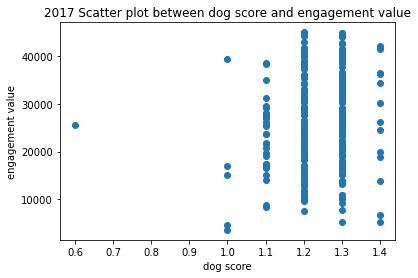

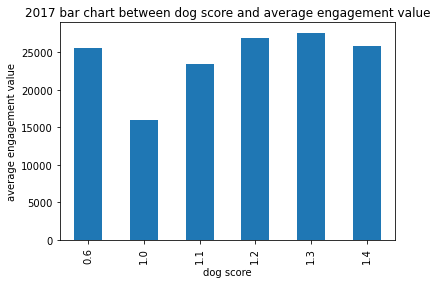

Year:	2016
corelation between dog score and engagement value:	0.2973444574777374
Tweet counts:	975


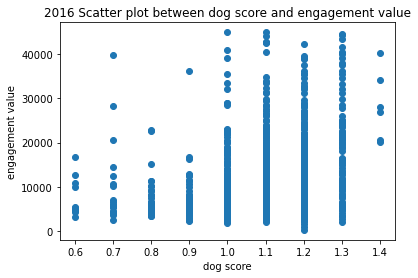

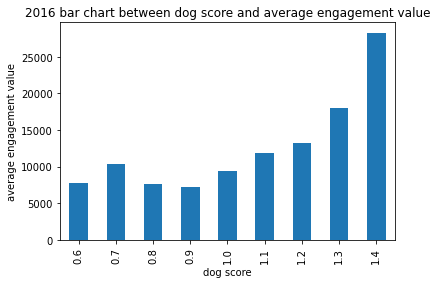

Year:	2015
corelation between dog score and engagement value:	0.18358688739051557
Tweet counts:	597


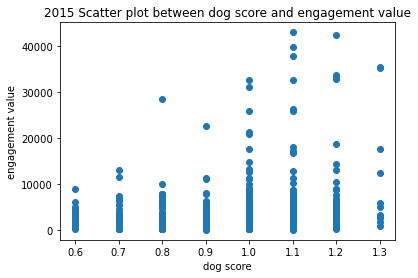

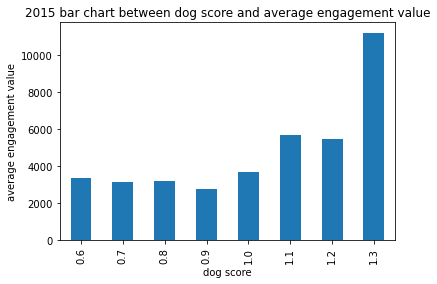

In [43]:
cond = '''
        engage_value < @max_value and \
        engage_value > @min_value and \
        year == @Year\
        '''
engage_score_relation(cond)

#### Conclusions:
- it is evident that form the average graphs that there is a +ve corelation between dog score and engagement value in general 
- also the corelation cofficient is always +ve each year and hovers betwen 0.1-0.3
- the year in which dog score affected engagement value the most was 2016
- the year with the highest number of tweets (more than 50% of the total) is 2016
- In 2017 WeRateDogs almost exlusively gave scores higher than 1 i.e (10/10)  while before ratings could either be higher or lower than 1

Year:	2017
corelation between dog score and engagement value:	0.11778351861919749
Tweet counts:	88


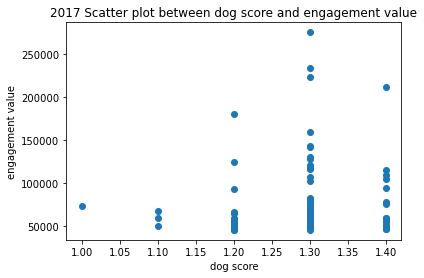

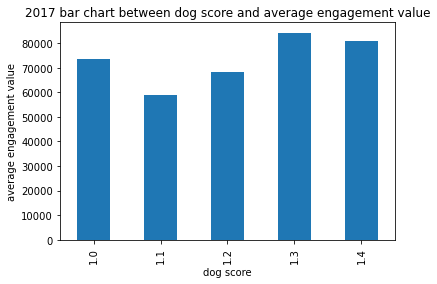

Year:	2016
corelation between dog score and engagement value:	0.16356130890068263
Tweet counts:	48


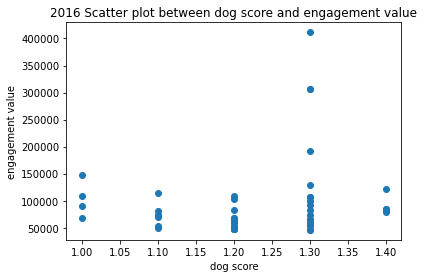

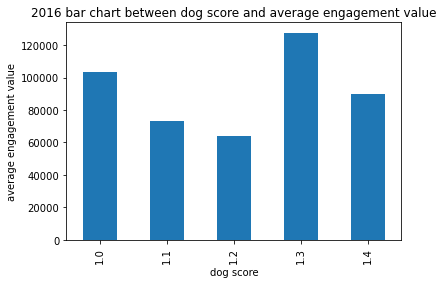

Year:	2015
corelation between dog score and engagement value:	-0.2577821068330604
Tweet counts:	9


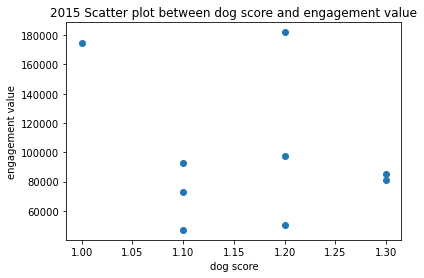

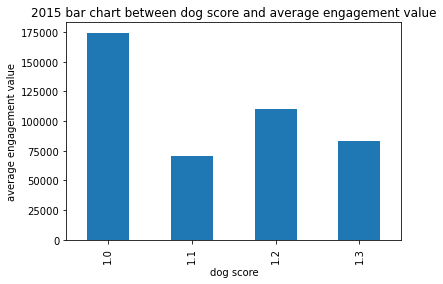

In [44]:
cond = '''
        engage_value > @max_value and \
        year == @Year\
        '''
engage_score_relation(cond)

#### Conclusions:
- 2015 has the lowest number of 'hit' tweets (9 tweets) while 2017 has the highest number of 'hit' tweets  (88 tweets)
- hit tweets doesn't seem to be affected much by the score
- Tweets in 2017 are far better ( in terms of engagement value per tweet) than other years as it has the least amount of tweets yet the highest amount of hit tweets, nearly one of every four tweets is considered a hit compared to previous years


### Dogs dataframe analysis

In [45]:
dog_df.describe()

,tweet_id,score,p1_conf,p2_conf,p3_conf,dog_breed_conf
count,1.997000e+03,1997.000000,1875.000000,1.875000e+03,1.875000e+03,1624.000000
mean,7.383087e+17,1.088032,0.596141,1.353536e-01,6.022567e-02,0.551926
std,6.727286e+16,0.167056,0.271075,1.013968e-01,5.104869e-02,0.298129
min,6.660209e+17,0.600000,0.044333,1.011300e-08,1.740170e-10,0.000010
25%,6.776876e+17,1.000000,0.365171,5.409535e-02,1.622240e-02,0.307482
50%,7.123094e+17,1.100000,0.594467,1.186510e-01,4.918190e-02,0.551119
75%,7.903376e+17,1.200000,0.845270,1.961285e-01,9.180755e-02,0.822062
max,8.924206e+17,1.400000,1.000000,4.880140e-01,2.734190e-01,0.999956


In [46]:
filtered_dog_df = dog_df.query('dog_breed_conf > 0.5')
filtered_dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 909 entries, 2 to 1995
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        909 non-null    int64  
 1   name            909 non-null    object 
 2   score           909 non-null    float64
 3   dog_category    163 non-null    object 
 4   p1              909 non-null    object 
 5   p1_conf         909 non-null    float64
 6   p1_dog          909 non-null    object 
 7   p2              909 non-null    object 
 8   p2_conf         909 non-null    float64
 9   p2_dog          909 non-null    object 
 10  p3              909 non-null    object 
 11  p3_conf         909 non-null    float64
 12  p3_dog          909 non-null    object 
 13  dog_breed       909 non-null    object 
 14  dog_breed_conf  909 non-null    float64
dtypes: float64(5), int64(1), object(9)
memory usage: 113.6+ KB


#### Relation between score,dog category and dog breed

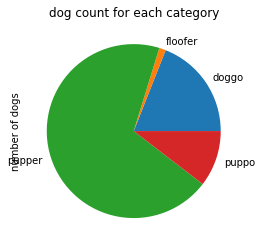

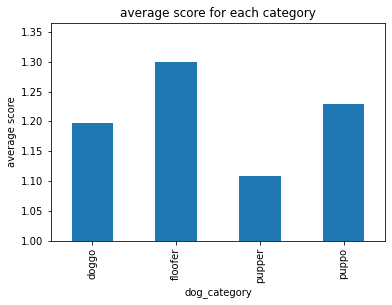

score                                            
              count      mean      std  min  25%  50%  75%  max
dog_category                                                   
doggo          31.0  1.196774  0.12776  0.8  1.1  1.2  1.3  1.4
floofer         2.0  1.300000  0.00000  1.3  1.3  1.3  1.3  1.3
pupper        113.0  1.108850  0.12288  0.8  1.0  1.1  1.2  1.4
puppo          17.0  1.229412  0.11048  1.0  1.2  1.3  1.3  1.4

In [47]:
stats = filtered_dog_df.groupby('dog_category')[['score']].describe()
stats.iloc[:,0].plot(kind='pie')
plt.ylabel('number of dogs')
plt.title('dog count for each category')
plt.show()
stats.iloc[:,1].plot(kind='bar')
plt.ylabel('average score')
plt.title('average score for each category')
plt.ylim(ymin=1)
plt.show()
stats

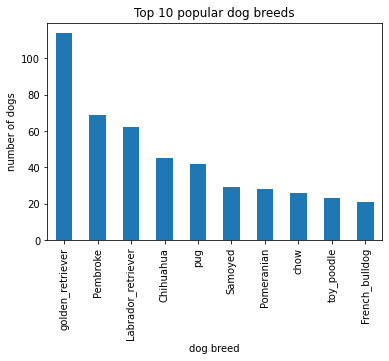

In [49]:
top_10_dogs = filtered_dog_df.dog_breed.value_counts()[:10]
top_10_dogs.plot(kind='bar')
plt.title('Top 10 popular dog breeds')
plt.xlabel('dog breed')
plt.ylabel('number of dogs')
plt.show()


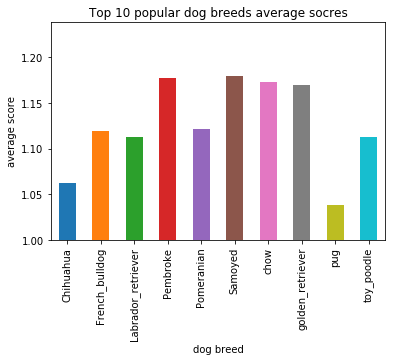

In [219]:
dog_names = top_10_dogs.index.tolist()
stats = filtered_dog_df.query('dog_breed == @dog_names').groupby('dog_breed').score.describe()
stats.iloc[:,1].plot(kind = 'bar')
plt.title('Top 10 popular dog breeds average socres')
plt.xlabel('dog breed')
plt.ylabel('average score')
plt.ylim(ymin=1)
plt.show()

#### Conclusions:
- most dogs that are classified are classified as puppers (113) and almost no dogs are classified as floofer (only 2!)
- most common dog type in WeRateDogs is the golden retreiver 
- pupper although the most common type has the least average score (1.1) while doggo and puppo seems to be equal (around 1.2)
- some dog breeds tends to have a higher score than other breeds like golden retriver and chow, while others tend to be lower like pug and chihuahua